In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from scipy.optimize import minimize

# Irradiance Data

In [72]:
# Read the irradiance data from the CSV file
dfIrr2 = pd.read_csv('../20240918_position2_rayonet.csv', skiprows=[1])
dfIrr2.columns = ['AbsoluteIrradiance:245', 'Unnamed: 1']

# Round the wavelengths to the nearest whole number
dfIrr2['rounded_wavelength'] = dfIrr2['AbsoluteIrradiance:245'].round()

dfIrr2.loc[dfIrr2['rounded_wavelength'] < 300, 'Unnamed: 1'] = 0

# Filter the DataFrame to include only wavelengths from 200 to 800
filtered_df1 = dfIrr2[(dfIrr2['rounded_wavelength'] >= 200) & (dfIrr2['rounded_wavelength'] <= 800)]

# Group by the rounded wavelengths and calculate the average irradiance
average_irradiance2 = filtered_df1.groupby('rounded_wavelength')['Unnamed: 1'].mean().reset_index()

# Rename the columns for clarity
average_irradiance2.columns = ['wavelength', 'average_irradiance']

Irr2=average_irradiance2['average_irradiance']
wavelengthIrr=average_irradiance2['wavelength']

#UNIT CONVERSION: Starting in µW*cm-2*nm-1 converting to mmolphotons*cm-2*s-1*nm-1
c=3*10**8 #m/s
h=6.626*10**-34 #J s
Na=6.023*10**23 #mol^-1

Irr2=Irr2/10E3 #µW to W
Irr2=(Irr2*wavelengthIrr*10E-10)/(h*c*Na)

Irr2=Irr2.astype(float)
wavelengthIrr=wavelengthIrr.astype(float)
I_rel2=Irr2/np.sum(Irr2)

# PNA/Pyr Actinometry

0.00043529046377098495

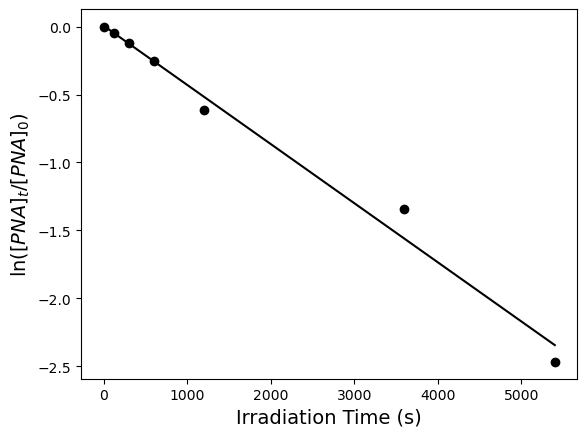

In [166]:
#HPLC data
#Change times to match your times of sampling
times=np.array([0, 2, 5, 10, 20, 60, 90])*60 #put in times and convert to seconds
PNA=[43.7, 41.8, 38.8, 33.9, 23.6, 11.4, 3.7] #put hplc data here 

#Change times to match your times of sampling
#Calculate kobs here
PNAlog=np.log([i/PNA[0] for i in PNA])
kpna=-(np.polyfit(times,PNAlog,1)[0])
b=-(np.polyfit(times,PNAlog,1)[1])
plt.plot(times,-kpna*times-b,'k-')
plt.plot(times,PNAlog,'ko')
plt.xlabel('Irradiation Time (s)',size=14)
plt.ylabel('ln(${[PNA]_t}$/${[PNA]_0}$)',size=14)
#plt.savefig('PNA_DEG.png')
kpna

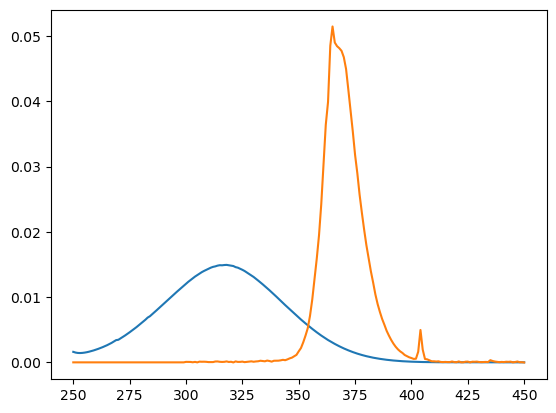

In [167]:
#load in EPNA
dfpna=pd.read_csv('../TELL ME WHY/epna.csv')
EPNA=dfpna['e (M-1 cm-1)'] #M cm^-1 
wavelengthpna=dfpna['wavelength']

#Take a subset of irradiance, to match and check
I_rel_sub=I_rel2[50:251]
#I_rel_sub=I_rel_sub.reset_index(drop=True)

I_rel_sub=I_rel_sub[::-1] #Reverse the array since it is backwards

plt.plot(wavelengthpna,EPNA/np.sum(EPNA))
plt.plot(wavelengthpna,I_rel_sub)

In [168]:
l=1
pyr0=10E-3
pna0=10E-6
quantumPNA=0.29*pyr0+2.9E-4

scaling_factor=(kpna*pna0*l)/(quantumPNA*np.sum(I_rel_sub.reset_index(drop=True)*(1-10**(-EPNA*pna0*l))))
scaling_factor

3.464146551054638e-05

12.923212357215379

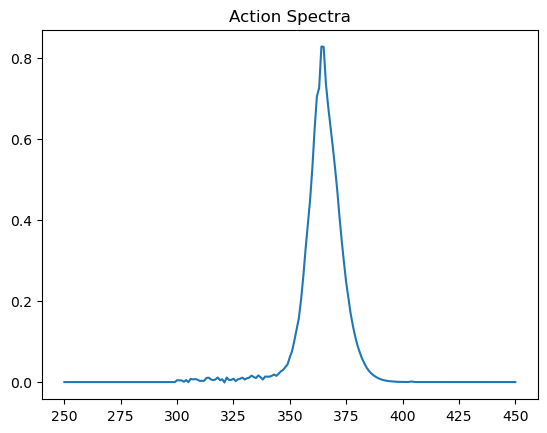

In [169]:
action_spectra=2.303*quantumPNA*EPNA*I_rel_sub.reset_index(drop=True)
plt.plot(wavelengthpna,action_spectra)
plt.title('Action Spectra')
#Calculate action spectra
np.sum(action_spectra)
#plt.savefig('Action')

In [170]:
I_abs_PNA=scaling_factor*I_rel2.reset_index(drop=True)

# 2NB Actinometry

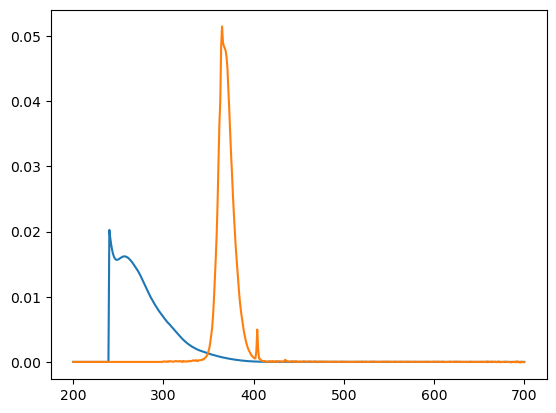

In [171]:
#First you will need to upload your csv file to this server
df = pd.read_csv('../intercomparison.csv')
wavelength_2NB=df['λ (nm)']
E2NB=df['2NB E']
E2NB=E2NB[:501]
wavelength_2NB=wavelength_2NB[:501]

I_rel_sub=I_rel2[:501]
I_rel_sub=I_rel_sub[::-1]

plt.plot(wavelength_2NB,E2NB/np.sum(E2NB))
plt.plot(wavelength_2NB,I_rel_sub)

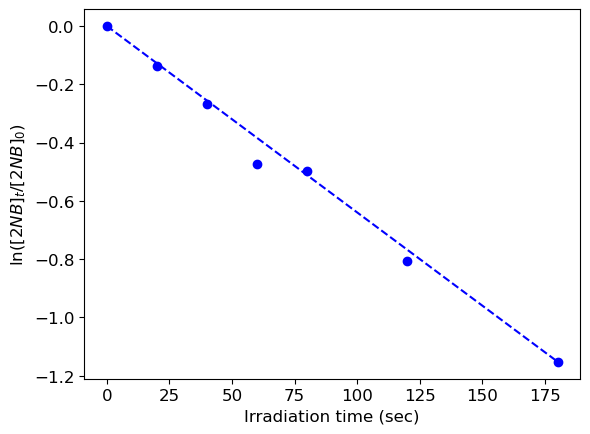

In [172]:
times=np.array([0,20,40,60,80,120,180]) 
deg=[150.1, 130.8, 114.8, 93.5, 91.3, 66.9, 47.4]
deglog=np.log([i/deg[0] for i in deg])
kobs_2NB=-(np.polyfit(times,deglog,1)[0])
#Plot the results
plt.plot(times,deglog,'bo')
plt.plot(times,times*(-kobs_2NB),'b--')

#Plot legend and axis labels
#plt.legend(fontsize=14)
plt.ylabel('ln(${[2NB]_t}$/${[2NB]_0}$)',fontsize=12)
plt.xlabel('Irradiation time (sec)',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.savefig('2NB_decay')
plt.show()

In [173]:
quantum2NB=0.41
def optimize_scaling_factor(quantum2NB, E2NB, I_rel_sub, known_value):
    """
    Optimize the scaling factor to match the known action_spectra value.

    Parameters:
        quantum2NB: Quantum yield.
        E2NB (pandas.Series or np.ndarray): Molar absorptivity data.
        I_rel_sub (pandas.Series or np.ndarray): Relative intensity data.
        known_value (float): The known action_spectra value to match.

    Returns:
        float: The optimal scaling factor.
    """
    # Reset index and ensure inputs are numpy arrays for better performance
    quantum2NB = quantum2NB
    E2NB = E2NB
    I_rel_sub = I_rel_sub.reset_index(drop=True).values

    # Objective function to minimize the error
    def objective(scaling_factor):
        action_spectra = 2.303 * scaling_factor * quantum2NB * E2NB * I_rel_sub
        error = np.abs(np.sum(action_spectra) - known_value)  # Minimize absolute error
        return error

    # Initial guess for the scaling factor
    initial_guess = 1.0

    # Perform the optimization
    result = minimize(objective, initial_guess, method='Nelder-Mead',tol=1e-10)

    if result.success:
        optimal_scaling_factor = result.x[0]
        
        # Calculate the optimized action_spectra with the optimal scaling factor
        optimized_action_spectra = 2.303 * optimal_scaling_factor * quantum2NB * E2NB * I_rel_sub
        optimized_value = np.sum(optimized_action_spectra)

        # Print the known and optimized values for confirmation
        print(f"Known value: {known_value}")
        print(f"Optimized action_spectra value: {optimized_value}")

        return optimal_scaling_factor
    else:
        raise ValueError("Optimization failed: " + result.message)

# Example usage:
scaling_factor = optimize_scaling_factor(quantum2NB, E2NB, I_rel_sub, kobs_2NB)
#print(f"Optimized scaling factor: {scaling_factor}")
#print(kobs_2NB)

Known value: 0.006399884398712476
Optimized action_spectra value: 0.006399884264457448


In [174]:
I_abs_2NB=I_rel2.reset_index(drop=True)*scaling_factor

In [175]:
c=3*10**8 #m/s
h=6.626*10**-34 #J s
Na=6.023*10**23 #mol^-1
#I_abs then has units of mol photons cm^-2 s^-1 nm^-1
print('I_abs_PNA=',np.sum(I_abs_PNA.reset_index(drop=True)*h*c*Na*10**10/wavelengthIrr.reset_index(drop=True)),'W m^2')
print('I_abs_2NB=',np.sum(I_abs_2NB.reset_index(drop=True)*h*c*Na*10**10/wavelengthIrr.reset_index(drop=True)),'W m^2')


I_abs_PNA= 111.73756852482819 W m^2
I_abs_2NB= 109.51684614069481 W m^2


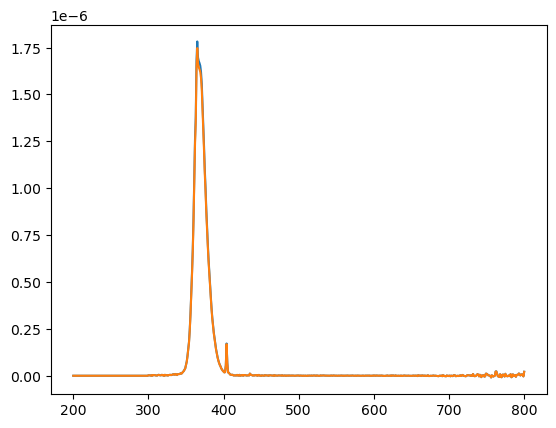

In [176]:
plt.plot(wavelengthIrr,I_abs_PNA)
plt.plot(wavelengthIrr,I_abs_2NB)

# Calculate Quantum yields using absolute irradiance

In [177]:
df1 = pd.read_csv('Nov12024_all_intercomparison.csv', skiprows=[1]) #change the name of the csv file to the name of the file you imported
df2 = pd.read_csv('nov182024_intercompall.csv', skiprows=[1]) #change the name of the csv file to the name of the file you imported

#Note: It's weird, but when reading in the csv file to python, it sometimes auto-names the samples to "unnamed: #" 
#extract absorbances (remember that because of the layout of the csv file the absorbances will sometimes be 
#named "Unnamed: x (odd number). Just check that you are indexing the correct names when assigning variables
blank=df1['Unnamed: 1']
PN_abs = df2['Unnamed: 9']
RB_abs = df2['Unnamed: 3'] 
Lig_abs = df2['Unnamed: 5']
Jug_abs = df2['Unnamed: 7']
wavelength=df1['blank']

PN_abs=PN_abs-blank
RB_abs=RB_abs-blank
Lig_abs=Lig_abs-blank
Jug_abs=Jug_abs-blank

PN_abs=PN_abs-np.mean(PN_abs[0:100])
RB_abs=RB_abs-np.mean(RB_abs[0:100])
Lig_abs=Lig_abs-np.mean(Lig_abs[0:100])
Jug_abs=Jug_abs-np.mean(Jug_abs[0:100])

#change all absorbances to type 'float' for ease of calculations 
RB_abs=RB_abs.astype(float)
PN_abs=PN_abs.astype(float)
Lig_abs=Lig_abs.astype(float)
Jug_abs=Jug_abs.astype(float)
wavelength=wavelength.astype(float)

RB_abs[RB_abs < 0] = 0
PN_abs[PN_abs < 0] = 0
Lig_abs[Lig_abs < 0] = 0
Jug_abs[Jug_abs < 0] = 0

wavelength=wavelength[::-1]
PN_abs=PN_abs[::-1]
RB_abs=RB_abs[::-1]
Lig_abs=Lig_abs[::-1]
Jug_abs=Jug_abs[::-1]

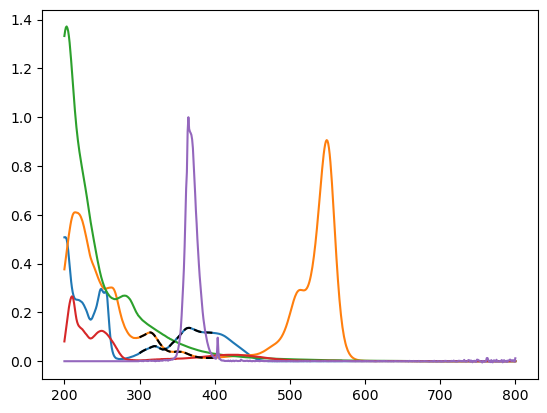

In [178]:
#plt.plot(wavelength,I_abs_2NB/np.max(I_abs_2NB))
plt.plot(wavelength,PN_abs)
plt.plot(wavelength,RB_abs)
plt.plot(wavelength,Lig_abs)
plt.plot(wavelength,Jug_abs)

plt.plot(wavelength[100:201],PN_abs[100:201],'--k')
plt.plot(wavelength[100:201],RB_abs[100:201],'--k')

plt.plot(wavelength,I_abs_2NB/np.max(I_abs_2NB))

In [179]:
#Change times to match your times of sampling
timesR=np.array([0, 1, 2, 3, 5, 15, 20])*60 #put in times and convert to seconds
PNtime=np.array([0, 0.5, 1, 1.5, 2, 3, 5])*60 #put in times and convert to seconds
times=np.array([0, 10, 30, 60, 90, 120, 150])*60
timesL=np.array([0, 10, 60, 90, 120, 150])*60

#Put in HPLC Results Here
RB=[69.5, 67.4, 62.7, 62.3, 55, 38.9, 32.9] 
PN=[91.4, 89.5, 82.5, 68.9, 76.1, 73.7, 50.5] 
PN=[72.4, 67.3, 60.7, 55.4, 51, 43, 30] 
Lig=[64.3, 63.2, 62.7, 62.3, 58.8, 57.1] 
Jug=[67.5, 66.4, 66.8, 65.9, 63.4, 62.3, 61.8]

#Don't worry, np.log is the natural logorithm, not base 10 (np.log10 is base 10)
RBlog=np.log([i/RB[0] for i in RB])
PNlog=np.log([i/PN[0] for i in PN])
Liglog=np.log([i/Lig[0] for i in Lig])
Juglog=np.log([i/Jug[0] for i in Jug])

kobsRB=-(np.polyfit(timesR,RBlog,1)[0])
kobsPN=-(np.polyfit(PNtime,PNlog,1)[0])
kobsLig=-(np.polyfit(timesL,Liglog,1)[0])
kobsJug=-(np.polyfit(times,Juglog,1)[0])

In [180]:
#plt.plot(timesR,RBlog,'o')
#plt.plot(timesR,-kobsRB*timesR)

#plt.plot(PNtime,PNlog,'o')
#plt.plot(PNtime,-kobsPN*PNtime)

#plt.plot(times,Juglog,'o')
#plt.plot(times,-kobsJug*times)

#plt.plot(timesL,Liglog,'o')
#plt.plot(timesL,-kobsLig*timesL)

# Calculate screening factor and Rate of light absorbance

# Using 2NB actinometry

In [88]:
#First subset absorbance to only include where there is irradiation 
alpha_PN=PN_abs[100:201]
alpha_RB=RB_abs[100:201]

I_2NB_sf=I_abs_2NB[100:201]

################################################################################
sf_PN=(np.sum((1-10**-alpha_PN.reset_index(drop=True))*I_2NB_sf.reset_index(drop=True)))/(np.sum((2.303*alpha_PN.reset_index(drop=True))*I_2NB_sf.reset_index(drop=True)))
print('PN Screening Factor = ',sf_PN)

sf_RB=(np.sum((1-10**-alpha_RB.reset_index(drop=True))*I_2NB_sf.reset_index(drop=True)))/(np.sum((2.303*alpha_RB.reset_index(drop=True))*I_2NB_sf.reset_index(drop=True)))
print('RB Screening Factor = ',sf_RB)

################################################################################
R_abs_PN=2.303*np.sum(PN_abs.reset_index(drop=True)*I_abs_2NB.reset_index(drop=True))
print('R_abs PN =',R_abs_PN)

R_abs_RB=2.303*np.sum(RB_abs.reset_index(drop=True)*I_abs_2NB.reset_index(drop=True))
print('R_abs RB =',R_abs_RB)

PN Screening Factor =  0.8649414480614436
RB Screening Factor =  0.969036799230943
R_abs PN = 9.9310117575855e-06
R_abs RB = 1.9512486537077607e-06


In [95]:
Temp=22
krxn=10**8 + (2.1E6*(Temp-22)) #from Appaini (2017)
kd=934.1813872772475*Temp + 258405.55551958136

kcorr_PN=kobsPN/sf_PN 
quantum_PN=(kcorr_PN*kd)/(R_abs_PN*krxn)
print('PN Quantum yield=',quantum_PN*100)

kcorr_RB=kobsRB/sf_RB
quantum_RB=(kcorr_RB*kd)/(R_abs_RB*krxn)
print('RB Quantum yield=',quantum_RB*100)

PN Quantum yield= 95.68978853837984
RB Quantum yield= 92.00176326726422


In [90]:
#First subset absorbance to only include where there is irradiation 
alpha_Lig=Lig_abs[100:201]
alpha_Jug=Jug_abs[100:201]

I_2NB_sf=I_abs_2NB[100:201]

################################################################################
sf_Lig=(np.sum((1-10**-alpha_Lig.reset_index(drop=True))*I_2NB_sf.reset_index(drop=True)))/(np.sum((2.303*alpha_Lig.reset_index(drop=True))*I_2NB_sf.reset_index(drop=True)))
print('Lig Screening Factor = ',sf_Lig)

sf_Jug=(np.sum((1-10**-alpha_Jug.reset_index(drop=True))*I_2NB_sf.reset_index(drop=True)))/(np.sum((2.303*alpha_Jug.reset_index(drop=True))*I_2NB_sf.reset_index(drop=True)))
print('Jug Screening Factor = ',sf_Jug)

################################################################################
R_abs_Lig=2.303*np.sum(Lig_abs.reset_index(drop=True)*I_abs_2NB.reset_index(drop=True))
print('R_abs Lig =',R_abs_Lig)

R_abs_Jug=2.303*np.sum(Jug_abs.reset_index(drop=True)*I_abs_2NB.reset_index(drop=True))
print('R_abs Jug =',R_abs_Jug)

Lig Screening Factor =  0.9386639892210932
Jug Screening Factor =  0.9837967837954623
R_abs Lig = 4.136876674097136e-06
R_abs Jug = 1.078135998212578e-06


In [96]:
Temp=22
krxn=10**8 + (2.1E6*(Temp-22)) #from Appaini (2017)
kd=934.1813872772475*Temp + 258405.55551958136

kcorr_Lig=kobsLig/sf_Lig
quantum_Lig=(kcorr_Lig*kd)/(R_abs_Lig*krxn)
print('Lig Quantum yield=',quantum_Lig*100)

kcorr_Jug=kobsJug/sf_Jug
quantum_Jug=(kcorr_Jug*kd)/(R_abs_Jug*krxn)
print('Jug Quantum yield=',quantum_Jug*100)

Lig Quantum yield= 0.8600241459404625
Jug Quantum yield= 2.689327792893038


In [97]:
print('QY RB Relative=',(kcorr_RB/R_abs_RB)*(R_abs_PN/kcorr_PN))
print('QY Lig Relative=',(kcorr_Lig/R_abs_Lig)*(R_abs_PN/kcorr_PN))
print('QY Jug Relative=',(kcorr_Jug/R_abs_Jug)*(R_abs_PN/kcorr_PN))

QY RB Relative= 0.9614585283607728
QY Lig Relative= 0.008987627196976392
QY Jug Relative= 0.028104647674233138


In [94]:
print('RB_SS=',kcorr_RB/krxn)
print('PN_SS=',kcorr_PN/krxn)
print('Lig_SS=',kcorr_Jug/krxn)
print('Jug_SS=',kcorr_Lig/krxn)

RB_SS= 6.368458683033122e-12
PN_SS= 3.371201093400161e-11
Lig_SS= 1.0285913206596225e-13
Jug_SS= 1.2621436510478069e-13


# Using PNA/Pyr actinometry

In [184]:
#First subset absorbance to only include where there is irradiation 
alpha_PN=PN_abs[100:201]
alpha_RB=RB_abs[100:201]

I_PNA_sf=I_abs_PNA[100:201]

################################################################################
sf_PN=(np.sum((1-10**-alpha_PN.reset_index(drop=True))*I_2NB_sf.reset_index(drop=True)))/(np.sum((2.303*alpha_PN.reset_index(drop=True))*I_PNA_sf.reset_index(drop=True)))
print('PN Screening Factor = ',sf_PN)

sf_RB=(np.sum((1-10**-alpha_RB.reset_index(drop=True))*I_2NB_sf.reset_index(drop=True)))/(np.sum((2.303*alpha_RB.reset_index(drop=True))*I_PNA_sf.reset_index(drop=True)))
print('RB Screening Factor = ',sf_RB)

################################################################################
R_abs_PN=2.303*np.sum(PN_abs.reset_index(drop=True)*I_abs_PNA.reset_index(drop=True))
print('R_abs PN =',R_abs_PN)

R_abs_RB=2.303*np.sum(RB_abs.reset_index(drop=True)*I_abs_PNA.reset_index(drop=True))
print('R_abs RB =',R_abs_RB)

PN Screening Factor =  0.8477512150893703
RB Screening Factor =  0.9497777287185669
R_abs PN = 1.0132387353069956e-05
R_abs RB = 1.990815000941063e-06


In [185]:
Temp=22
krxn=10**8 + (2.1E6*(Temp-22)) #from Appaini (2017)
kd=934.1813872772475*Temp + 258405.55551958136

kcorr_PN=kobsPN/sf_PN 
quantum_PN=(kcorr_PN*kd)/(R_abs_PN*krxn)
print('PN Quantum yield=',quantum_PN*100)

kcorr_RB=kobsRB/sf_RB
quantum_RB=(kcorr_RB*kd)/(R_abs_RB*krxn)
print('RB Quantum yield=',quantum_RB*100)

PN Quantum yield= 95.68978853837984
RB Quantum yield= 92.00176326726424


In [183]:
#First subset absorbance to only include where there is irradiation 
alpha_Lig=Lig_abs[100:201]
alpha_Jug=Jug_abs[100:201]

I_PNA_sf=I_abs_PNA[100:201]

################################################################################
sf_Lig=(np.sum((1-10**-alpha_Lig.reset_index(drop=True))*I_PNA_sf.reset_index(drop=True)))/(np.sum((2.303*alpha_Lig.reset_index(drop=True))*I_PNA_sf.reset_index(drop=True)))
print('Lig Screening Factor = ',sf_Lig)

sf_Jug=(np.sum((1-10**-alpha_Jug.reset_index(drop=True))*I_PNA_sf.reset_index(drop=True)))/(np.sum((2.303*alpha_Jug.reset_index(drop=True))*I_PNA_sf.reset_index(drop=True)))
print('Jug Screening Factor = ',sf_Jug)

################################################################################
R_abs_Lig=2.303*np.sum(Lig_abs.reset_index(drop=True)*I_abs_PNA.reset_index(drop=True))
print('R_abs Lig =',R_abs_Lig)

R_abs_Jug=2.303*np.sum(Jug_abs.reset_index(drop=True)*I_abs_PNA.reset_index(drop=True))
print('R_abs Jug =',R_abs_Jug)

Lig Screening Factor =  0.9386639892210932
Jug Screening Factor =  0.9837967837954623
R_abs Lig = 4.220761984479108e-06
R_abs Jug = 1.099997847131189e-06
